<a href="https://colab.research.google.com/github/LauraGDev/Transfer_learning_dogs/blob/main/IABM02B0_EAC6_Ex1_Laura_Gil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificació d'imatges a color fent servir una xarxa preentrenada

En aquest *notebook* farem servir una arquitectura de model preentrenat per a classificar imatges de 5 races de gossos.

In [ ]:
# Començarem important les llibreries
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


##Lectura del *dataset*

Obtindrem el *dataset* d'un enllaç. Aquest *dataset* contindrà imatges en categories sota el nom "flower_fotos".

Com farem servir la funció image_dataset_from_directory de tensorflow, podríem fer servir imatges pròpies si les guardéssim adientment en l'estructura requerida de carpetes.
Per a fer-ho, caldria que ens creéssim una carpeta d'entrenament i una de validació amb el següent format:

/directori/dades/

    /clase_1

        imagen1.jpg

        imagen2.jpg

        ...

    /clase_2

        imagen1.jpg

        imagen2.jpg

        ...

    ...

In [ ]:
# Ruta al dataset de gossos que tinc al meu drive
data_dir ="/content/drive/MyDrive/IOC/IABD/M2/data/dog_photos"

batch_size = 256
img_height = 224
img_width = 224

##Anàlisi del*dataset*

In [ ]:
# Mirem quantes imatges tenim per cada categoria
categories = os.listdir(data_dir)

# Ho guardarem en un diccionari
flower_counts = {}

# Iterem per a cada categoria
for category in categories:
    category_path = os.path.join(data_dir, category)
    if os.path.isdir(category_path):
        # Contem el nombre d'imatges dins de cada categoria
        num_files = len(os.listdir(category_path))
        flower_counts[category] = num_files

# Mostrem el recompte de flors
print("Races de gos per categoria")
for category, count in flower_counts.items():
    print(f"{category}: {count} imatges")

Races de gos per categoria
Border_collie: 150 imatges
Doberman: 150 imatges
Beagle: 195 imatges
Pug: 200 imatges
Pitbull: 164 imatges


In [ ]:
# Creem el conjunt de dades d'entrenament i validació
train_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=1234,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)
val_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=1234,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)


Found 859 files belonging to 5 classes.
Using 688 files for training.
Found 859 files belonging to 5 classes.
Using 171 files for validation.


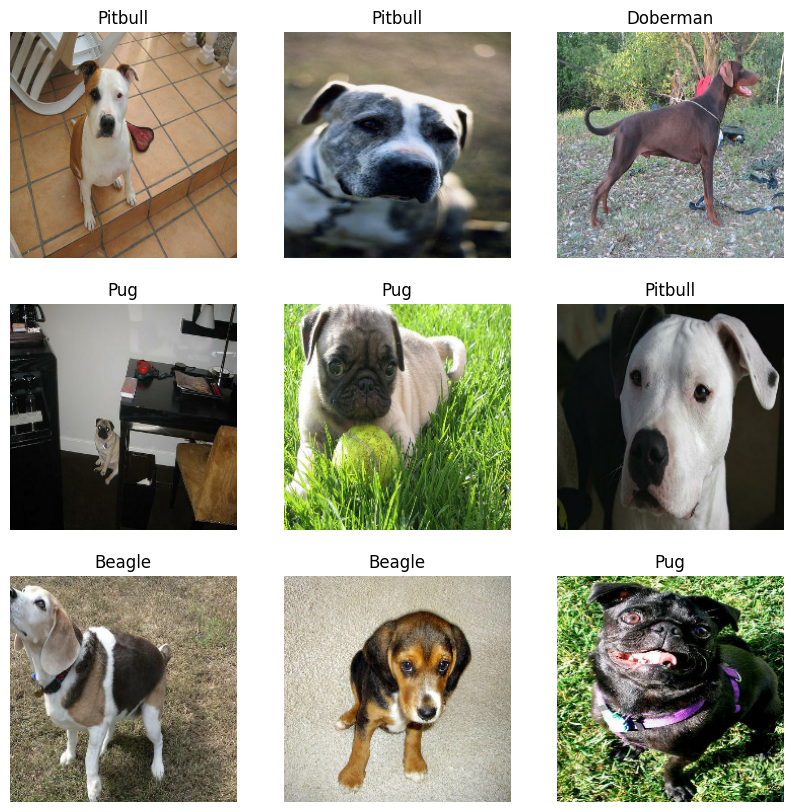

In [ ]:
#Ara visualitzarem algunes imatges a mode d'exemple.

# Definim les etiquetes de les classes.
class_names = train_ds.class_names

# Iterem sobre el conjunt de dades de validació i mostrem algunes imatges
for images, labels in val_ds.take(1):  # Agafem només el primer batch per a fer l'exemple
    plt.figure(figsize=(10, 10))
    for i in range(9):  # Mostrem 9 imatges
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()


## Carreguem el model i l'entrenem

In [ ]:
# Carreguem el model ResNet preentrenat amb 'imagenet'
base_model = ResNet50(weights='imagenet', include_top=False)


94765736/94765736 [==============================] - 3s 0us/step


In [ ]:
# Congelem les capes base del model preentrenat
base_model.trainable = False

# Construim el model de classificació sobre el model base
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = base_model(inputs, training=False)
x = Flatten()(x)
outputs = Dense(5, activation='softmax')(x)
model = Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048   23587712  
                             )                                   
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 5)                 501765    
                                                                 
Total params: 24089477 (91.89 MB)
Trainable params: 501765 (1.91 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [ ]:
# Compilem el model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Entrenem el model
epochs = 5
model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/5
3/3 [==============================] - 177s 10s/step - loss: 18.2060 - accuracy: 0.2631 - val_loss: 12.1576 - val_accuracy: 0.6082
Epoch 2/5
3/3 [==============================] - 6s 1s/step - loss: 10.7400 - accuracy: 0.6628 - val_loss: 8.1155 - val_accuracy: 0.6725
Epoch 3/5
3/3 [==============================] - 6s 1s/step - loss: 3.2397 - accuracy: 0.8052 - val_loss: 5.2580 - val_accuracy: 0.7544
Epoch 4/5
3/3 [==============================] - 5s 1s/step - loss: 1.5360 - accuracy: 0.8721 - val_loss: 5.6807 - val_accuracy: 0.7310
Epoch 5/5
3/3 [==============================] - 6s 1s/step - loss: 0.4953 - accuracy: 0.9390 - val_loss: 3.4699 - val_accuracy: 0.8538


##Obtenció de mètriques

In [ ]:
# Avaluem el model
loss, accuracy = model.evaluate(val_ds)
print(f'Pèrdua: {loss}, Taxa d\'encert: {accuracy}')

1/1 [==============================] - 1s 1s/step - loss: 3.4699 - accuracy: 0.8538
Pèrdua: 3.4699389934539795, Taxa d'encert: 0.8538011908531189


6/6 [==============================] - 5s 331ms/step


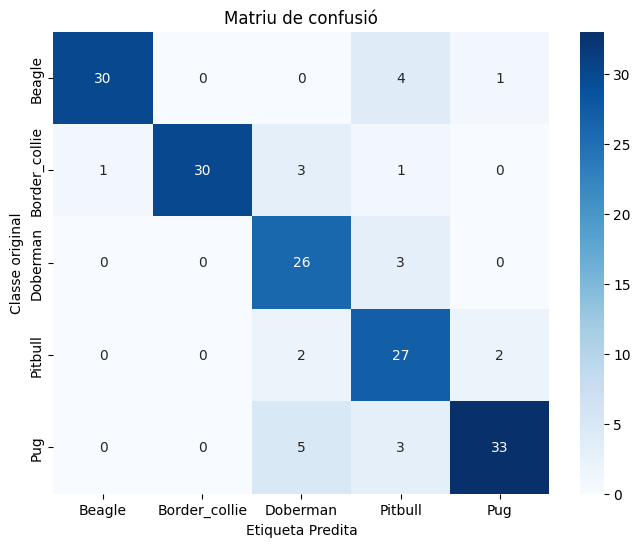

In [ ]:
# Obtenim el nom de les etiquetes
true_labels = []
predicted_labels = []
imatges = []
for imgs, labels in val_ds:
    true_labels.extend(labels.numpy())
    imatges.extend(imgs)
    # Obtenim les prediccions en el conjunt de dades de validació
    predicted_probs = model.predict(imgs)
    predicted_labels.extend(np.argmax(predicted_probs, axis=1))

# Mostrem la matriu de confusió
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Etiqueta Predita')
plt.ylabel('Classe original')
plt.title('Matriu de confusió')
plt.show()

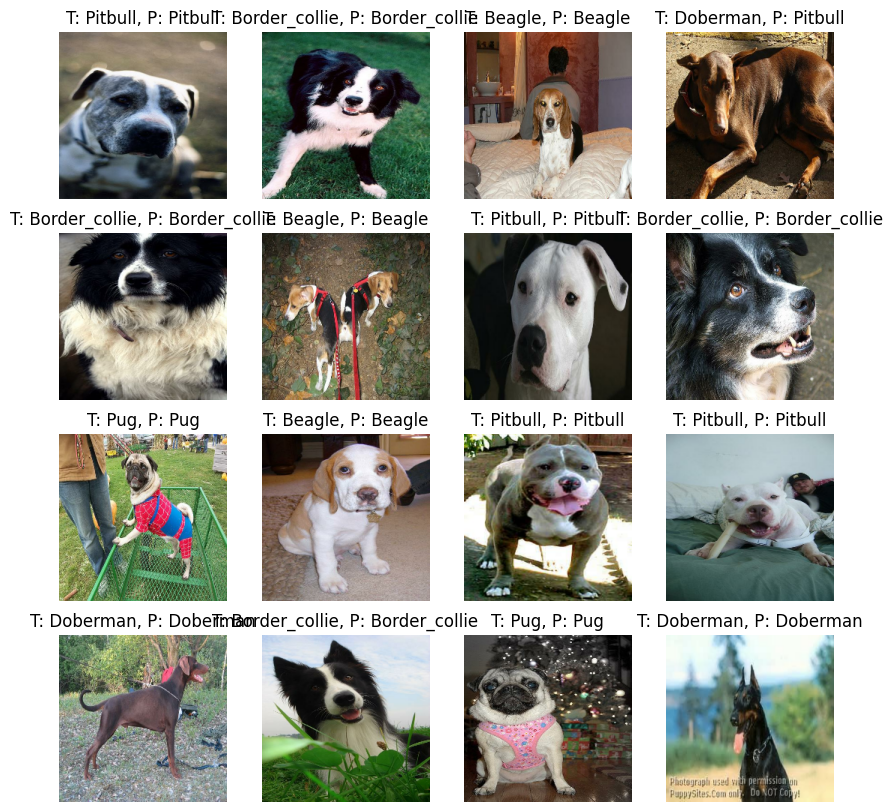

In [ ]:
# Mostrem algunes imatges per veure si les prediccions han estat encertades.
plt.figure(figsize=(10, 10))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(imatges[i].numpy().astype("uint8"))
    plt.title(f"T: {class_names[true_labels[i]]}, P: {class_names[predicted_labels[i]]}")
    plt.axis("off")
plt.show()

### Validació amb imatges de fora del dataset

Com que no tinc gossos he buscat per internet imatges on sigui una mica difícil diferenciar la raça. He agafat de **beagles, carlins, dòbermans i pitbulls** perquè són les races que més ha confós.

##### Prova nivell fàcil

1/1 [==============================] - 0s 22ms/step


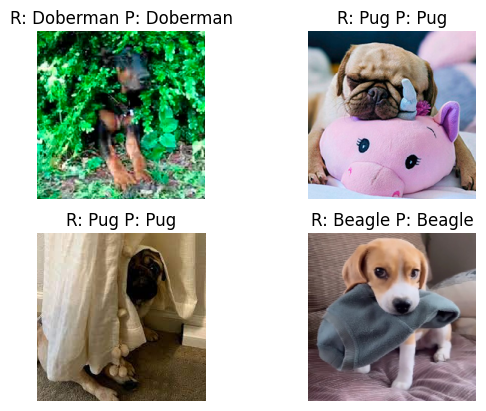

In [ ]:
from tensorflow.keras.preprocessing import image
path = "/content/drive/MyDrive/IOC/IABD/M2/data/Gossos_test/easy"
carpeta_imatges = os.listdir(path)
imatges_noves = []
labels_predites = []
labels_reals = ["Doberman", "Pug", "Pug", "Beagle"]
for img in carpeta_imatges:
    img_path = os.path.join(path, img)
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    # Obtenim les prediccions en el conjunt de dades de validació
    predicted_probs = model.predict(img)
    imatges_noves.extend(img)
    labels_predites.extend(np.argmax(predicted_probs, axis=1))

for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(imatges_noves[i].astype('uint8'))
    plt.title(f"R: {labels_reals[i]} P: {class_names[labels_predites[i]]}")
    plt.axis("off")
plt.show()


######Prova més difícil.
Només amb **pitbulls**, ja que si no es veuen les orelles o té el cap una mica tapat sol fallar.


1/1 [==============================] - 0s 25ms/step


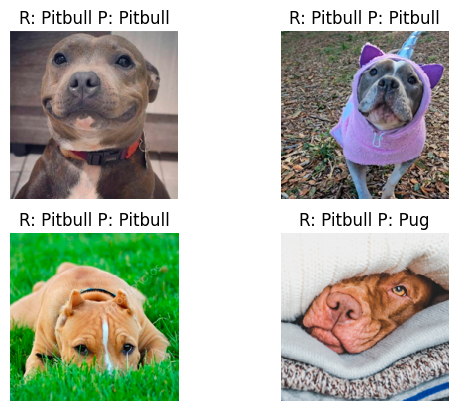

In [ ]:
path = "/content/drive/MyDrive/IOC/IABD/M2/data/Gossos_test/hard"
carpeta_imatges = os.listdir(path)
imatges_noves_dificils = []
labels_predites_dificils = []
labels_reals_dificils = ["Pitbull", "Pitbull", "Pitbull", "Pitbull"]
for img in carpeta_imatges:
    img_path = os.path.join(path, img)
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    # Obtenim les prediccions en el conjunt de dades de validació
    predicted_probs = model.predict(img)
    imatges_noves_dificils.extend(img)
    labels_predites_dificils.extend(np.argmax(predicted_probs, axis=1))

for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(imatges_noves_dificils[i].astype('uint8'))
    plt.title(f"R: {labels_reals_dificils[i]} P: {class_names[labels_predites_dificils[i]]}")
    plt.axis("off")
plt.show()

#Conclusions

El model fa molt bon treball i l'entrenament es fa en segons gràcies al model preentrenat. És cert que confon bastant els pitbulls i beagles per carlins, però crec que augmentant una miqueta les èpoques o el learning-rate pot arribar a un percentatge molt alt de precisió.